In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



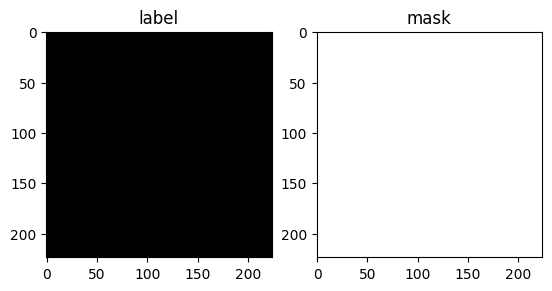

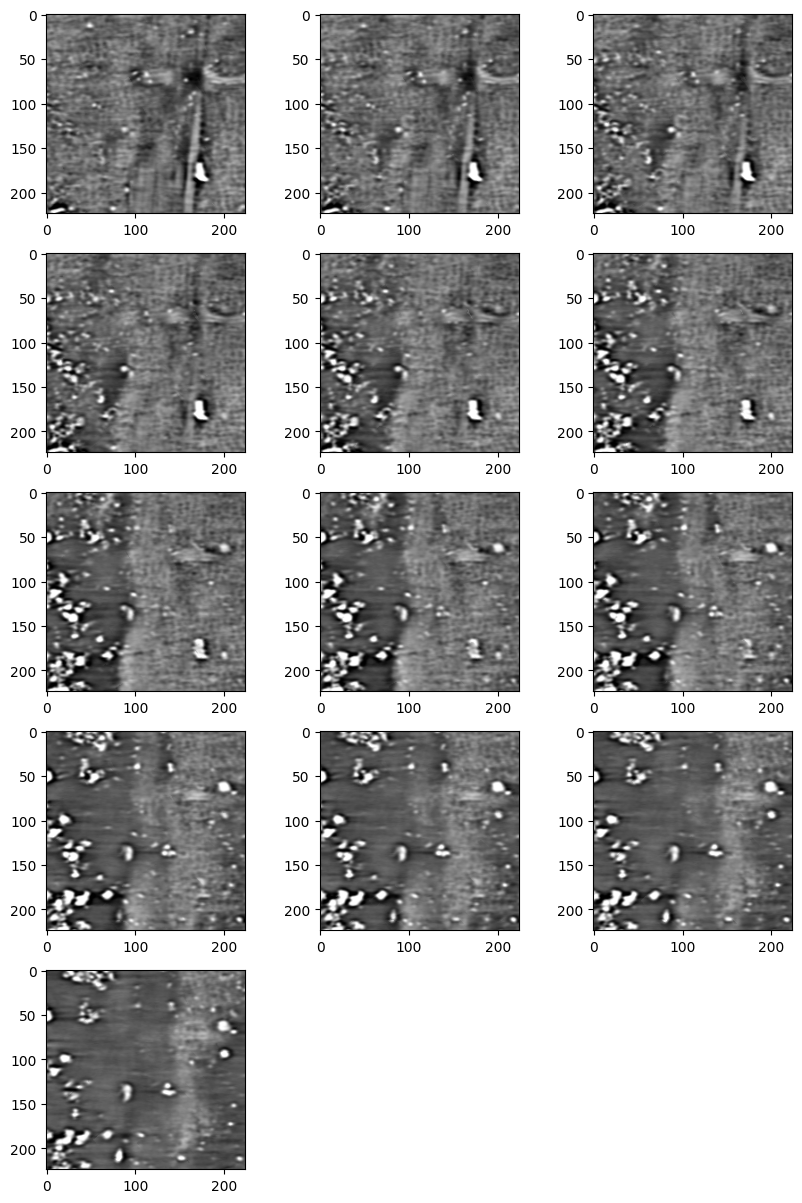

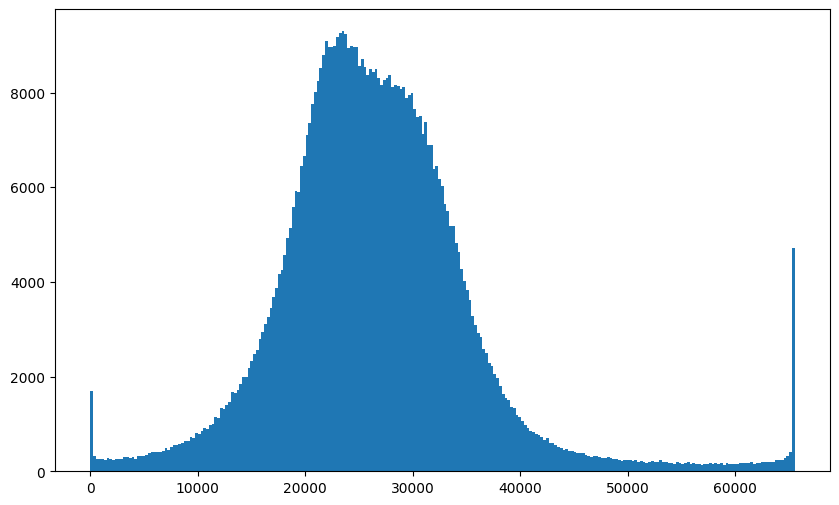

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


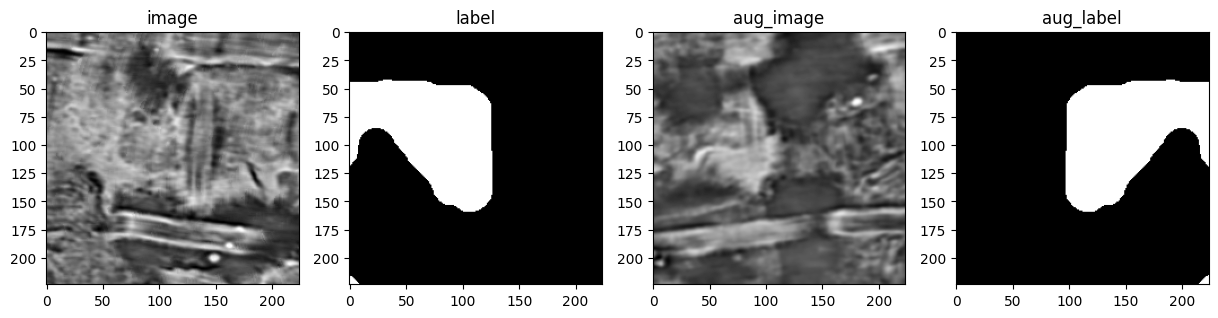

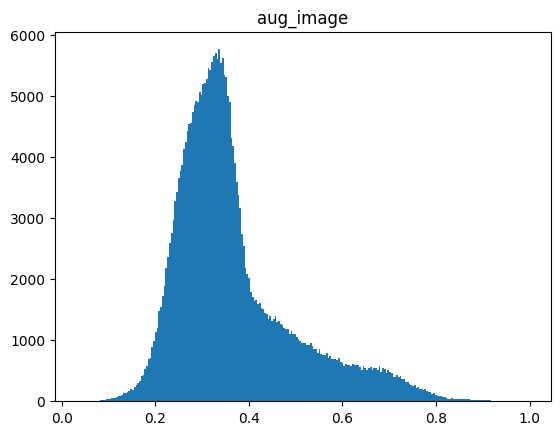

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 21.89it/s]


fbeta: 0.2554
Epoch 1 - avg_train_loss: 0.7585  avg_val_loss: 0.6136  avgScore: 0.2554  time: 76s
Epoch 1 - Save Best Loss: 0.6136  Best Score: 0.2554 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.34it/s]


fbeta: 0.2943
Epoch 2 - avg_train_loss: 0.7168  avg_val_loss: 0.6035  avgScore: 0.2943  time: 70s
Epoch 2 - Save Best Loss: 0.6035  Best Score: 0.2943 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.30it/s]


fbeta: 0.3860
Epoch 3 - avg_train_loss: 0.6712  avg_val_loss: 0.5903  avgScore: 0.3860  time: 70s
Epoch 3 - Save Best Loss: 0.5903  Best Score: 0.3860 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.21it/s]


fbeta: 0.3305
Epoch 4 - avg_train_loss: 0.6180  avg_val_loss: 0.5753  avgScore: 0.3305  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.34it/s]


fbeta: 0.3838
Epoch 5 - avg_train_loss: 0.5914  avg_val_loss: 0.5724  avgScore: 0.3838  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.36it/s]


fbeta: 0.3729
Epoch 6 - avg_train_loss: 0.5969  avg_val_loss: 0.5550  avgScore: 0.3729  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.32it/s]


fbeta: 0.3970
Epoch 7 - avg_train_loss: 0.5592  avg_val_loss: 0.5656  avgScore: 0.3970  time: 70s
Epoch 7 - Save Best Loss: 0.5656  Best Score: 0.3970 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.35it/s]


fbeta: 0.4035
Epoch 8 - avg_train_loss: 0.5568  avg_val_loss: 0.5378  avgScore: 0.4035  time: 70s
Epoch 8 - Save Best Loss: 0.5378  Best Score: 0.4035 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.02it/s]


fbeta: 0.3656
Epoch 9 - avg_train_loss: 0.5496  avg_val_loss: 0.5436  avgScore: 0.3656  time: 72s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.26it/s]


fbeta: 0.3795
Epoch 10 - avg_train_loss: 0.5426  avg_val_loss: 0.5393  avgScore: 0.3795  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.36it/s]


fbeta: 0.4015
Epoch 11 - avg_train_loss: 0.5227  avg_val_loss: 0.5220  avgScore: 0.4015  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.45it/s]


fbeta: 0.4231
Epoch 12 - avg_train_loss: 0.5253  avg_val_loss: 0.5818  avgScore: 0.4231  time: 70s
Epoch 12 - Save Best Loss: 0.5818  Best Score: 0.4231 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.38it/s]


fbeta: 0.3893
Epoch 13 - avg_train_loss: 0.5082  avg_val_loss: 0.5254  avgScore: 0.3893  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.57it/s]


fbeta: 0.4678
Epoch 14 - avg_train_loss: 0.5000  avg_val_loss: 0.5917  avgScore: 0.4678  time: 70s
Epoch 14 - Save Best Loss: 0.5917  Best Score: 0.4678 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.36it/s]


fbeta: 0.3917
Epoch 15 - avg_train_loss: 0.4970  avg_val_loss: 0.5157  avgScore: 0.3917  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.37it/s]


fbeta: 0.4268
Epoch 16 - avg_train_loss: 0.4793  avg_val_loss: 0.5586  avgScore: 0.4268  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.32it/s]


fbeta: 0.4346
Epoch 17 - avg_train_loss: 0.4806  avg_val_loss: 0.5321  avgScore: 0.4346  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.41it/s]


fbeta: 0.4777
Epoch 18 - avg_train_loss: 0.4741  avg_val_loss: 0.5620  avgScore: 0.4777  time: 69s
Epoch 18 - Save Best Loss: 0.5620  Best Score: 0.4777 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.30it/s]


fbeta: 0.4473
Epoch 19 - avg_train_loss: 0.4683  avg_val_loss: 0.5536  avgScore: 0.4473  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.17it/s]


fbeta: 0.4313
Epoch 20 - avg_train_loss: 0.4562  avg_val_loss: 0.5488  avgScore: 0.4313  time: 70s

fold: 1


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


fbeta: 0.1891
Epoch 1 - avg_train_loss: 0.7548  avg_val_loss: 0.5075  avgScore: 0.1891  time: 71s
Epoch 1 - Save Best Loss: 0.5075  Best Score: 0.1891 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.2443
Epoch 2 - avg_train_loss: 0.7098  avg_val_loss: 0.4923  avgScore: 0.2443  time: 71s
Epoch 2 - Save Best Loss: 0.4923  Best Score: 0.2443 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.99it/s]


fbeta: 0.3879
Epoch 3 - avg_train_loss: 0.6608  avg_val_loss: 0.5208  avgScore: 0.3879  time: 71s
Epoch 3 - Save Best Loss: 0.5208  Best Score: 0.3879 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.03it/s]


fbeta: 0.3841
Epoch 4 - avg_train_loss: 0.6074  avg_val_loss: 0.4539  avgScore: 0.3841  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.11it/s]


fbeta: 0.2639
Epoch 5 - avg_train_loss: 0.5920  avg_val_loss: 0.5901  avgScore: 0.2639  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.26it/s]


fbeta: 0.4254
Epoch 6 - avg_train_loss: 0.5691  avg_val_loss: 0.4555  avgScore: 0.4254  time: 71s
Epoch 6 - Save Best Loss: 0.4555  Best Score: 0.4254 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.16it/s]


fbeta: 0.4094
Epoch 7 - avg_train_loss: 0.5582  avg_val_loss: 0.4238  avgScore: 0.4094  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.20it/s]


fbeta: 0.3779
Epoch 8 - avg_train_loss: 0.5638  avg_val_loss: 0.4223  avgScore: 0.3779  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.01it/s]


fbeta: 0.4472
Epoch 9 - avg_train_loss: 0.5421  avg_val_loss: 0.4306  avgScore: 0.4472  time: 71s
Epoch 9 - Save Best Loss: 0.4306  Best Score: 0.4472 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.06it/s]


fbeta: 0.4198
Epoch 10 - avg_train_loss: 0.5420  avg_val_loss: 0.4853  avgScore: 0.4198  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.09it/s]


fbeta: 0.4398
Epoch 11 - avg_train_loss: 0.5151  avg_val_loss: 0.4290  avgScore: 0.4398  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.22it/s]


fbeta: 0.4155
Epoch 12 - avg_train_loss: 0.4923  avg_val_loss: 0.4269  avgScore: 0.4155  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.22it/s]


fbeta: 0.4775
Epoch 13 - avg_train_loss: 0.4956  avg_val_loss: 0.4850  avgScore: 0.4775  time: 71s
Epoch 13 - Save Best Loss: 0.4850  Best Score: 0.4775 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.4887
Epoch 14 - avg_train_loss: 0.4855  avg_val_loss: 0.4448  avgScore: 0.4887  time: 71s
Epoch 14 - Save Best Loss: 0.4448  Best Score: 0.4887 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.15it/s]


fbeta: 0.5679
Epoch 15 - avg_train_loss: 0.4772  avg_val_loss: 0.4506  avgScore: 0.5679  time: 72s
Epoch 15 - Save Best Loss: 0.4506  Best Score: 0.5679 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.20it/s]


fbeta: 0.5494
Epoch 16 - avg_train_loss: 0.4687  avg_val_loss: 0.4444  avgScore: 0.5494  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.5210
Epoch 17 - avg_train_loss: 0.4626  avg_val_loss: 0.4229  avgScore: 0.5210  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.27it/s]


fbeta: 0.5555
Epoch 18 - avg_train_loss: 0.4550  avg_val_loss: 0.4299  avgScore: 0.5555  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.04it/s]


fbeta: 0.5713
Epoch 19 - avg_train_loss: 0.4479  avg_val_loss: 0.4378  avgScore: 0.5713  time: 71s
Epoch 19 - Save Best Loss: 0.4378  Best Score: 0.5713 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.95it/s]


fbeta: 0.5487
Epoch 20 - avg_train_loss: 0.4418  avg_val_loss: 0.4258  avgScore: 0.5487  time: 72s

fold: 2


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.04it/s]


fbeta: 0.3021
Epoch 1 - avg_train_loss: 0.7538  avg_val_loss: 0.6864  avgScore: 0.3021  time: 71s
Epoch 1 - Save Best Loss: 0.6864  Best Score: 0.3021 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.97it/s]


fbeta: 0.3455
Epoch 2 - avg_train_loss: 0.6874  avg_val_loss: 0.6753  avgScore: 0.3455  time: 71s
Epoch 2 - Save Best Loss: 0.6753  Best Score: 0.3455 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


fbeta: 0.2985
Epoch 3 - avg_train_loss: 0.6581  avg_val_loss: 0.8513  avgScore: 0.2985  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


fbeta: 0.4052
Epoch 4 - avg_train_loss: 0.6325  avg_val_loss: 0.7067  avgScore: 0.4052  time: 71s
Epoch 4 - Save Best Loss: 0.7067  Best Score: 0.4052 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.18it/s]


fbeta: 0.3509
Epoch 5 - avg_train_loss: 0.6147  avg_val_loss: 0.6561  avgScore: 0.3509  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.4853
Epoch 6 - avg_train_loss: 0.5836  avg_val_loss: 0.6857  avgScore: 0.4853  time: 71s
Epoch 6 - Save Best Loss: 0.6857  Best Score: 0.4853 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.94it/s]


fbeta: 0.4457
Epoch 7 - avg_train_loss: 0.5620  avg_val_loss: 0.6357  avgScore: 0.4457  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.4885
Epoch 8 - avg_train_loss: 0.5572  avg_val_loss: 0.6881  avgScore: 0.4885  time: 71s
Epoch 8 - Save Best Loss: 0.6881  Best Score: 0.4885 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.87it/s]


fbeta: 0.5054
Epoch 9 - avg_train_loss: 0.5619  avg_val_loss: 0.6749  avgScore: 0.5054  time: 72s
Epoch 9 - Save Best Loss: 0.6749  Best Score: 0.5054 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.96it/s]


fbeta: 0.5110
Epoch 10 - avg_train_loss: 0.5466  avg_val_loss: 0.6813  avgScore: 0.5110  time: 72s
Epoch 10 - Save Best Loss: 0.6813  Best Score: 0.5110 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.06it/s]


fbeta: 0.5118
Epoch 11 - avg_train_loss: 0.5359  avg_val_loss: 0.6706  avgScore: 0.5118  time: 71s
Epoch 11 - Save Best Loss: 0.6706  Best Score: 0.5118 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.12it/s]


fbeta: 0.5449
Epoch 12 - avg_train_loss: 0.5165  avg_val_loss: 0.6750  avgScore: 0.5449  time: 71s
Epoch 12 - Save Best Loss: 0.6750  Best Score: 0.5449 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.88it/s]


fbeta: 0.5329
Epoch 13 - avg_train_loss: 0.5229  avg_val_loss: 0.6492  avgScore: 0.5329  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.10it/s]


fbeta: 0.5546
Epoch 14 - avg_train_loss: 0.5018  avg_val_loss: 0.6299  avgScore: 0.5546  time: 71s
Epoch 14 - Save Best Loss: 0.6299  Best Score: 0.5546 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.96it/s]


fbeta: 0.5573
Epoch 15 - avg_train_loss: 0.4895  avg_val_loss: 0.7113  avgScore: 0.5573  time: 72s
Epoch 15 - Save Best Loss: 0.7113  Best Score: 0.5573 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.38it/s]


fbeta: 0.5482
Epoch 16 - avg_train_loss: 0.4914  avg_val_loss: 0.6501  avgScore: 0.5482  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.40it/s]


fbeta: 0.5536
Epoch 17 - avg_train_loss: 0.4848  avg_val_loss: 0.6114  avgScore: 0.5536  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.17it/s]


fbeta: 0.5838
Epoch 18 - avg_train_loss: 0.4749  avg_val_loss: 0.6403  avgScore: 0.5838  time: 72s
Epoch 18 - Save Best Loss: 0.6403  Best Score: 0.5838 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.48it/s]


fbeta: 0.5885
Epoch 19 - avg_train_loss: 0.4792  avg_val_loss: 0.6554  avgScore: 0.5885  time: 73s
Epoch 19 - Save Best Loss: 0.6554  Best Score: 0.5885 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.61it/s]


fbeta: 0.5879
Epoch 20 - avg_train_loss: 0.4654  avg_val_loss: 0.6535  avgScore: 0.5879  time: 72s

fold: 3


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.27it/s]


fbeta: 0.2504
Epoch 1 - avg_train_loss: 0.7623  avg_val_loss: 0.5932  avgScore: 0.2504  time: 73s
Epoch 1 - Save Best Loss: 0.5932  Best Score: 0.2504 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.06it/s]


fbeta: 0.2993
Epoch 2 - avg_train_loss: 0.7203  avg_val_loss: 0.5906  avgScore: 0.2993  time: 73s
Epoch 2 - Save Best Loss: 0.5906  Best Score: 0.2993 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.02it/s]


fbeta: 0.3803
Epoch 3 - avg_train_loss: 0.6858  avg_val_loss: 0.5796  avgScore: 0.3803  time: 74s
Epoch 3 - Save Best Loss: 0.5796  Best Score: 0.3803 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.01it/s]


fbeta: 0.4327
Epoch 4 - avg_train_loss: 0.6297  avg_val_loss: 0.6100  avgScore: 0.4327  time: 73s
Epoch 4 - Save Best Loss: 0.6100  Best Score: 0.4327 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.30it/s]


fbeta: 0.4173
Epoch 5 - avg_train_loss: 0.6136  avg_val_loss: 0.6672  avgScore: 0.4173  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.00it/s]


fbeta: 0.4583
Epoch 6 - avg_train_loss: 0.5869  avg_val_loss: 0.6230  avgScore: 0.4583  time: 73s
Epoch 6 - Save Best Loss: 0.6230  Best Score: 0.4583 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.13it/s]


fbeta: 0.5140
Epoch 7 - avg_train_loss: 0.5789  avg_val_loss: 0.5589  avgScore: 0.5140  time: 73s
Epoch 7 - Save Best Loss: 0.5589  Best Score: 0.5140 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.15it/s]


fbeta: 0.5119
Epoch 8 - avg_train_loss: 0.5778  avg_val_loss: 0.5460  avgScore: 0.5119  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.21it/s]


fbeta: 0.4177
Epoch 9 - avg_train_loss: 0.5513  avg_val_loss: 0.5085  avgScore: 0.4177  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.10it/s]


fbeta: 0.4937
Epoch 10 - avg_train_loss: 0.5639  avg_val_loss: 0.5286  avgScore: 0.4937  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.54it/s]


fbeta: 0.5739
Epoch 11 - avg_train_loss: 0.5343  avg_val_loss: 0.5588  avgScore: 0.5739  time: 73s
Epoch 11 - Save Best Loss: 0.5588  Best Score: 0.5739 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.67it/s]


fbeta: 0.5216
Epoch 12 - avg_train_loss: 0.5357  avg_val_loss: 0.4953  avgScore: 0.5216  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.47it/s]


fbeta: 0.5715
Epoch 13 - avg_train_loss: 0.5170  avg_val_loss: 0.5114  avgScore: 0.5715  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.68it/s]


fbeta: 0.6004
Epoch 14 - avg_train_loss: 0.5050  avg_val_loss: 0.5240  avgScore: 0.6004  time: 72s
Epoch 14 - Save Best Loss: 0.5240  Best Score: 0.6004 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.69it/s]


fbeta: 0.5864
Epoch 15 - avg_train_loss: 0.4993  avg_val_loss: 0.4882  avgScore: 0.5864  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.59it/s]


fbeta: 0.6043
Epoch 16 - avg_train_loss: 0.4938  avg_val_loss: 0.4853  avgScore: 0.6043  time: 72s
Epoch 16 - Save Best Loss: 0.4853  Best Score: 0.6043 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.43it/s]


fbeta: 0.5898
Epoch 17 - avg_train_loss: 0.4791  avg_val_loss: 0.4910  avgScore: 0.5898  time: 73s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.57it/s]


fbeta: 0.6103
Epoch 18 - avg_train_loss: 0.4765  avg_val_loss: 0.4956  avgScore: 0.6103  time: 72s
Epoch 18 - Save Best Loss: 0.4956  Best Score: 0.6103 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.70it/s]


fbeta: 0.6250
Epoch 19 - avg_train_loss: 0.4768  avg_val_loss: 0.5235  avgScore: 0.6250  time: 72s
Epoch 19 - Save Best Loss: 0.5235  Best Score: 0.6250 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.53it/s]


fbeta: 0.5968
Epoch 20 - avg_train_loss: 0.4728  avg_val_loss: 0.5032  avgScore: 0.5968  time: 72s

fold: 4


100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 21.86it/s]


fbeta: 0.1862
Epoch 1 - avg_train_loss: 0.7370  avg_val_loss: 0.5650  avgScore: 0.1862  time: 74s
Epoch 1 - Save Best Loss: 0.5650  Best Score: 0.1862 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 21.71it/s]


fbeta: 0.2748
Epoch 2 - avg_train_loss: 0.6899  avg_val_loss: 0.5441  avgScore: 0.2748  time: 74s
Epoch 2 - Save Best Loss: 0.5441  Best Score: 0.2748 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.09it/s]


fbeta: 0.4143
Epoch 3 - avg_train_loss: 0.6520  avg_val_loss: 0.5139  avgScore: 0.4143  time: 74s
Epoch 3 - Save Best Loss: 0.5139  Best Score: 0.4143 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.39it/s]


fbeta: 0.4770
Epoch 4 - avg_train_loss: 0.6063  avg_val_loss: 0.5012  avgScore: 0.4770  time: 74s
Epoch 4 - Save Best Loss: 0.5012  Best Score: 0.4770 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.24it/s]


fbeta: 0.3871
Epoch 5 - avg_train_loss: 0.6046  avg_val_loss: 0.4734  avgScore: 0.3871  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.31it/s]


fbeta: 0.4787
Epoch 6 - avg_train_loss: 0.5798  avg_val_loss: 0.4693  avgScore: 0.4787  time: 74s
Epoch 6 - Save Best Loss: 0.4693  Best Score: 0.4787 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.18it/s]


fbeta: 0.4024
Epoch 7 - avg_train_loss: 0.5602  avg_val_loss: 0.4606  avgScore: 0.4024  time: 75s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.29it/s]


fbeta: 0.4614
Epoch 8 - avg_train_loss: 0.5541  avg_val_loss: 0.4552  avgScore: 0.4614  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.29it/s]


fbeta: 0.3973
Epoch 9 - avg_train_loss: 0.5376  avg_val_loss: 0.4609  avgScore: 0.3973  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.31it/s]


fbeta: 0.4329
Epoch 10 - avg_train_loss: 0.5262  avg_val_loss: 0.4427  avgScore: 0.4329  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.55it/s]


fbeta: 0.4446
Epoch 11 - avg_train_loss: 0.5403  avg_val_loss: 0.4515  avgScore: 0.4446  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.10it/s]


fbeta: 0.4761
Epoch 12 - avg_train_loss: 0.5161  avg_val_loss: 0.4378  avgScore: 0.4761  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.26it/s]


fbeta: 0.4642
Epoch 13 - avg_train_loss: 0.4960  avg_val_loss: 0.4261  avgScore: 0.4642  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.30it/s]


fbeta: 0.4838
Epoch 14 - avg_train_loss: 0.4948  avg_val_loss: 0.4396  avgScore: 0.4838  time: 74s
Epoch 14 - Save Best Loss: 0.4396  Best Score: 0.4838 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.28it/s]


fbeta: 0.3800
Epoch 15 - avg_train_loss: 0.4856  avg_val_loss: 0.4394  avgScore: 0.3800  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.18it/s]


fbeta: 0.4635
Epoch 16 - avg_train_loss: 0.4822  avg_val_loss: 0.4330  avgScore: 0.4635  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.25it/s]


fbeta: 0.4351
Epoch 17 - avg_train_loss: 0.4656  avg_val_loss: 0.4420  avgScore: 0.4351  time: 75s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.22it/s]


fbeta: 0.4519
Epoch 18 - avg_train_loss: 0.4587  avg_val_loss: 0.4370  avgScore: 0.4519  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.11it/s]


fbeta: 0.4304
Epoch 19 - avg_train_loss: 0.4500  avg_val_loss: 0.4433  avgScore: 0.4304  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.16it/s]


fbeta: 0.4516
Epoch 20 - avg_train_loss: 0.4573  avg_val_loss: 0.4406  avgScore: 0.4516  time: 74s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.4777
fbeta: 0.5713
fbeta: 0.5885
fbeta: 0.6250
fbeta: 0.4838


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5504


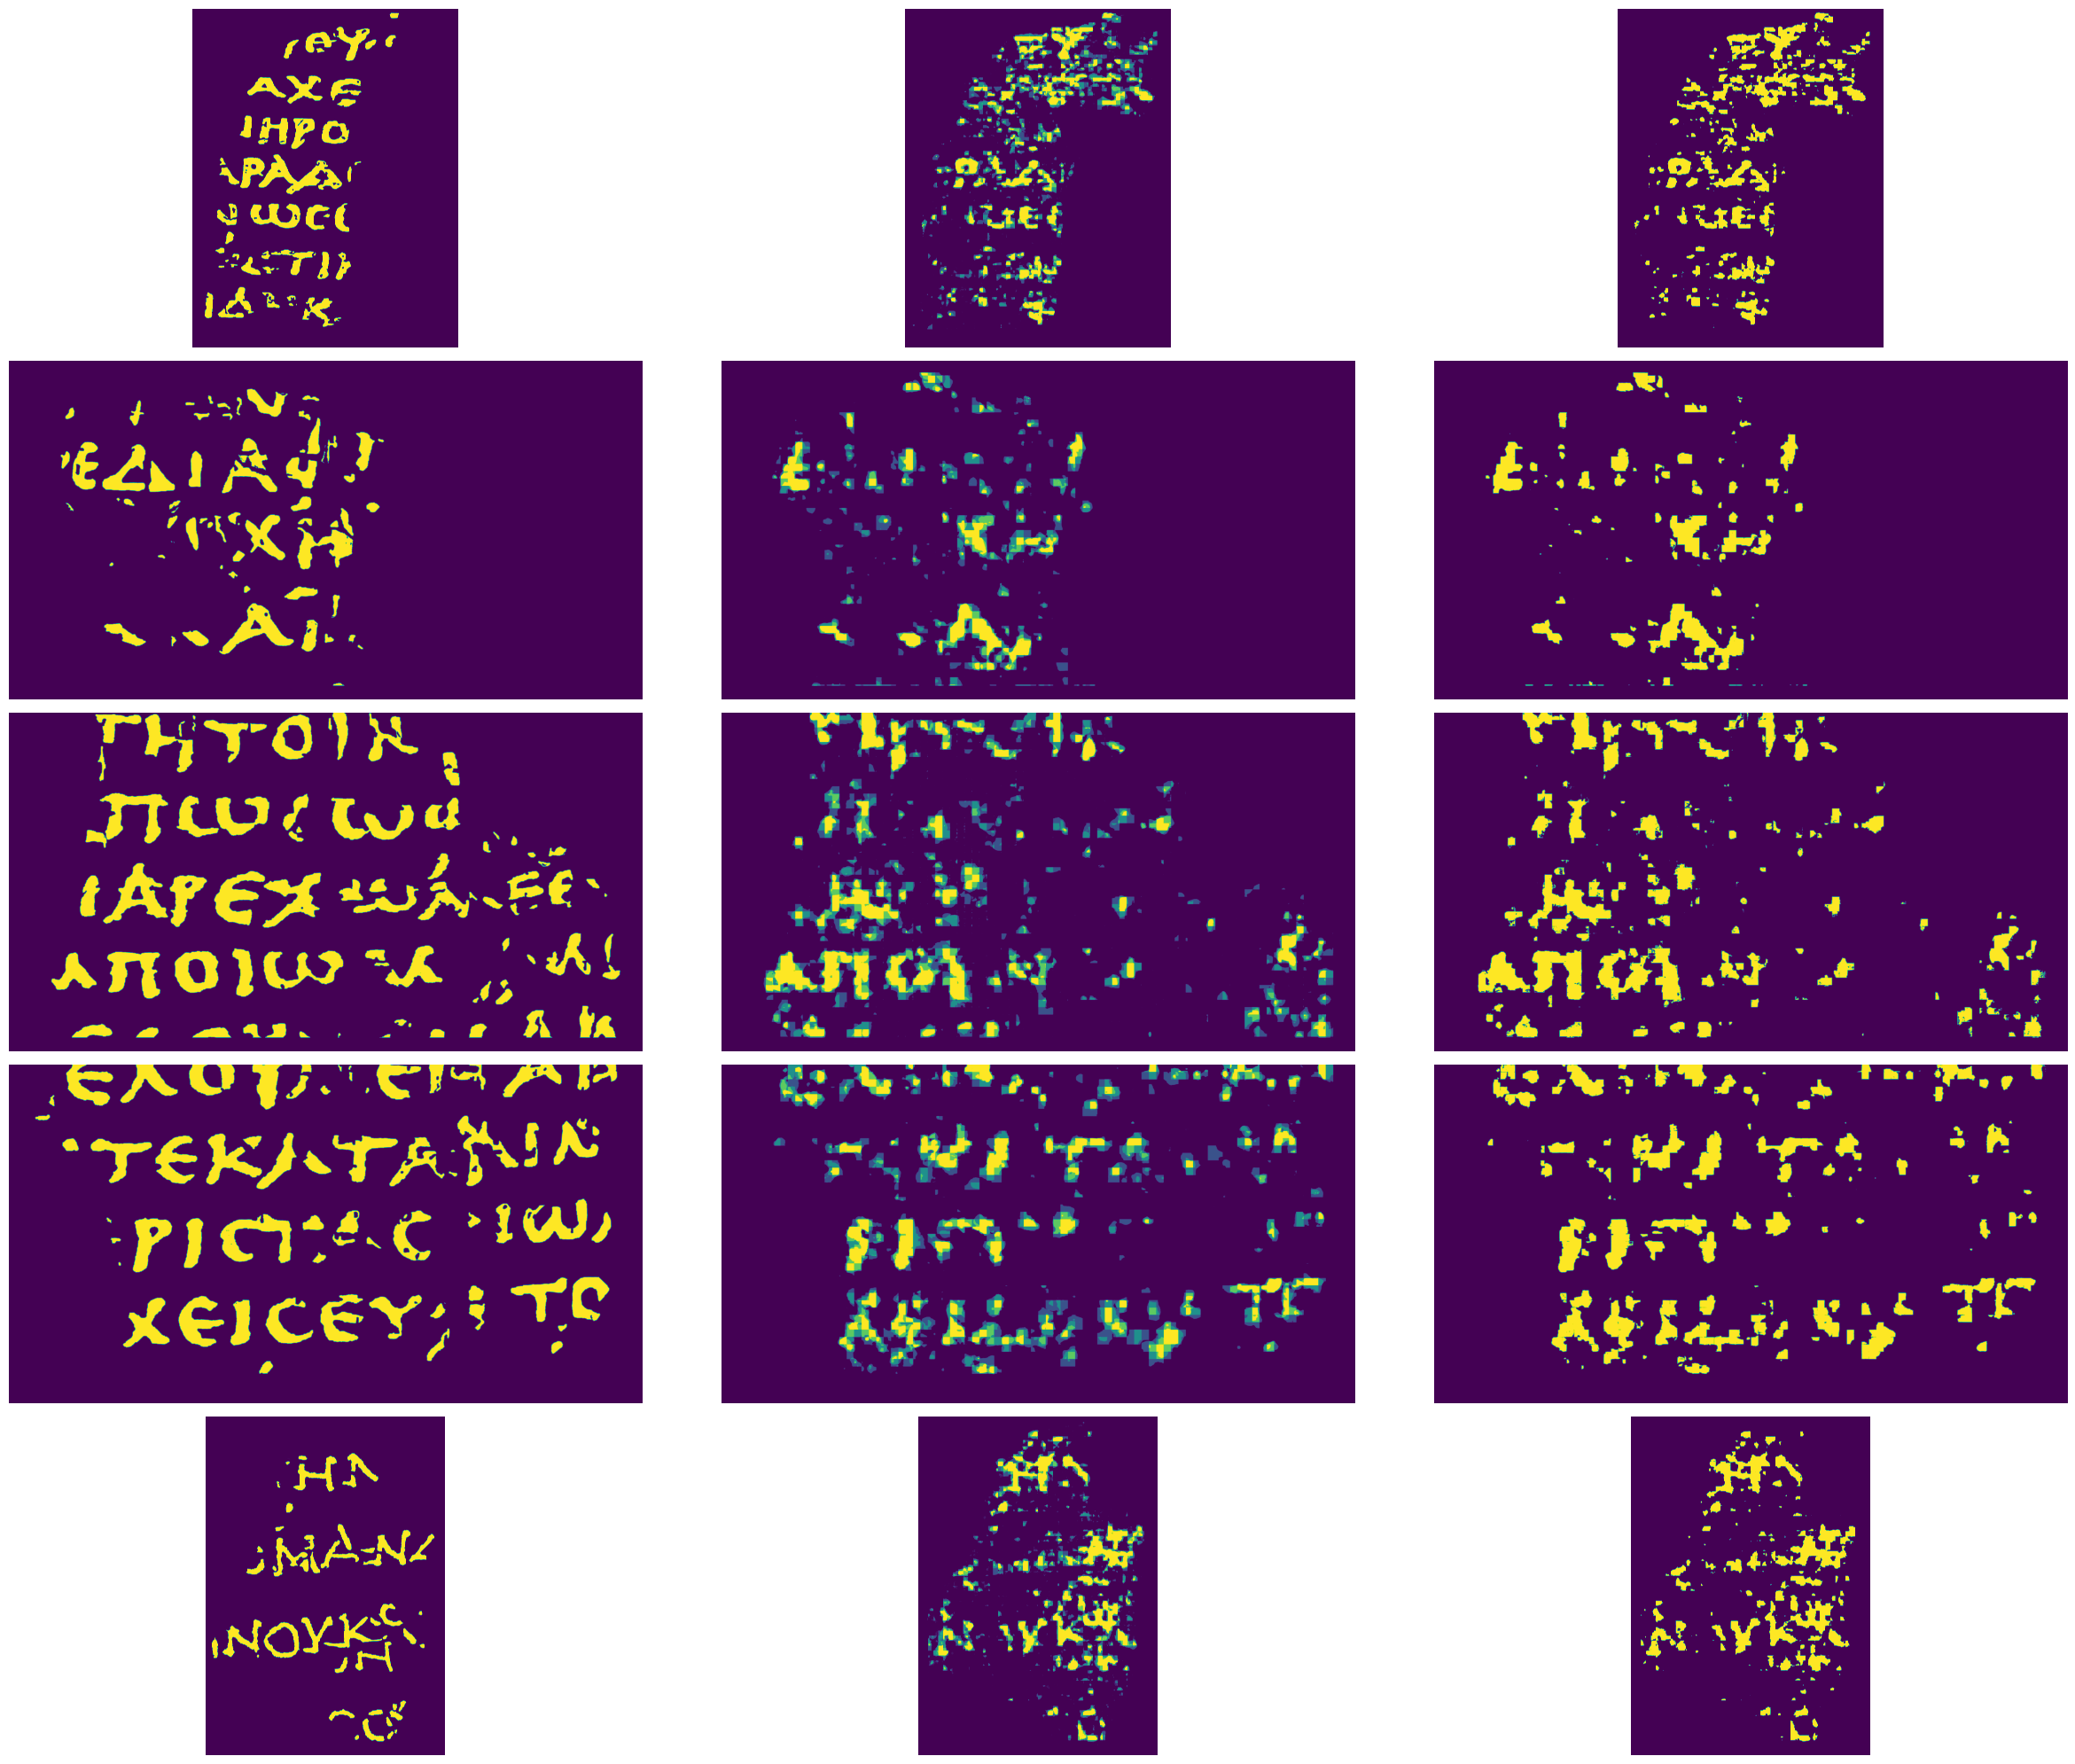

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)